# Plot for Summary Report: Top and Bottom Producers

In [27]:
%run 'helpers-for-report-plot-generation.ipynb'
from datetime import datetime

In [28]:
def retrieve_data():
    milk = get_dataset('milk_volume')
    milk = select_milk_features(milk)
    birthdates = get_dataset('birthdates')
    return milk, birthdates

def select_milk_features(milk):
    return milk[['animal_id','date','milk_weight']]

def append_cow_age_to_milk_dataframe(milk, birthdates):
    """ Adds a cows age in month for each day milked"""
    milk = milk.reset_index()
    milk = pd.merge(left=milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    milk['months_aged'] = (milk_with_ages['date'] - milk_with_ages['birthdate']).astype('timedelta64[M]')
    return milk

milk, birthdates = retrieve_data()

In [29]:
def number_of_days_in_period(start, end):
    start = datetime.strptime(start, '%m-%d-%Y')
    end = datetime.strptime(end, '%m-%d-%Y')
    return (start - end).days

def build_performance_profiles_for_period(milk, birthdates, start='1-1-2016', end='12-31-2017'):
    period_milk = milk.set_index('date')[start:end]
    period_milk = pd.merge(left=period_milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    
    days_in_period = number_of_days_in_period(start, end)
    
    profiles = []
    for animal_id in period_milk['animal_id'].unique():
        animal_milk_for_period = period_milk[period_milk['animal_id'] ==  animal_id]
        birthdates
        
        profile = {}
        profile['Animal ID'] = animal_id 
        profile['Days Milked'] = animal_milk_for_period.count()['animal_id']
        profile['Total Milk-Pounds'] = animal_milk_for_period['milk_weight'].sum()
        profile['Per Day Average'] = round(animal_milk_for_period['milk_weight'].mean(), 2)
        
        profile['Birthdate'] = animal_milk_for_period['birthdate'].values[0]
        
        profiles.append(profile)
        
    data = pd.DataFrame(profiles).set_index('Animal ID')
    return data.sort_values('Per Day Average', ascending=False)

performance_profiles = build_performance_profiles_for_period(milk, birthdates).sort_values('Per Day Average')
# Only consider animals that have milked more than 400 days over the 2 year period
performance_profiles = performance_profiles[performance_profiles['Days Milked'] > 400].reset_index()

In [30]:
bottom_ten = performance_profiles.head(13)
bottom_ten_milk_weight = bottom_ten.sum()["Total Milk-Pounds"]
print('Total Milk Weight produced by bottom 10% of herd', bottom_ten_milk_weight)

portion_of_total = bottom_ten_milk_weight / performance_profiles.sum()["Total Milk-Pounds"]
print('Percentage of milk produced by bottom 10% of herd:', portion_of_total)

print("\nBottom 10% of Producers:\n\n", bottom_ten)

Total Milk Weight produced by bottom 10% of herd 404183.8
Percentage of milk produced by bottom 10% of herd: 0.0787756272239

Bottom 10% of Producers:

     Animal ID  Birthdate  Days Milked  Per Day Average  Total Milk-Pounds
0        2009 2013-01-19          432            57.43            24809.6
1        2139 2014-08-10          454            58.48            26550.9
2        2140 2014-08-15          447            59.08            26406.7
3        2121 2014-05-21          423            60.51            25594.3
4        2158 2014-09-29          422            61.69            26032.6
5        2096 2014-01-10          567            61.79            35037.6
6        1961 2012-06-25          491            61.91            30398.7
7        2157 2014-09-28          438            62.62            27428.6
8        2073 2013-11-07          586            63.00            36917.5
9        2108 2014-02-21          541            63.84            34539.3
10       2074 2013-11-10         

In [31]:
top_ten = performance_profiles.tail(13)
top_ten_milk_weight = top_ten.sum()["Total Milk-Pounds"]
print('Total Milk Weight Produced by Top 10% of herd', top_ten_milk_weight)

portion_of_total = top_ten_milk_weight / performance_profiles.sum()["Total Milk-Pounds"]
print('Percentage of milk produced by Top 10% of herd:', portion_of_total)

print("\Top 10% of Producers:\n\n", top_ten)

Total Milk Weight Produced by Top 10% of herd 684803.5
Percentage of milk produced by Top 10% of herd: 0.133468548808
\Top 10% of Producers:

      Animal ID  Birthdate  Days Milked  Per Day Average  Total Milk-Pounds
114       1815 2010-12-02          628            85.96            53980.3
115       2030 2013-05-08          592            87.60            51856.6
116       1993 2012-11-11          486            87.77            42655.2
117       2133 2014-07-18          407            88.66            36084.6
118       1931 2012-02-06          514            88.95            45719.7
119       2045 2013-07-03          635            89.86            57059.9
120       1918 2011-12-12          585            91.30            53412.1
121       1531 2007-09-25          500            92.48            46238.3
122       1711 2009-09-19          454            92.69            42083.2
123       1729 2009-12-05          567            98.09            55615.7
124       2091 2014-01-01       

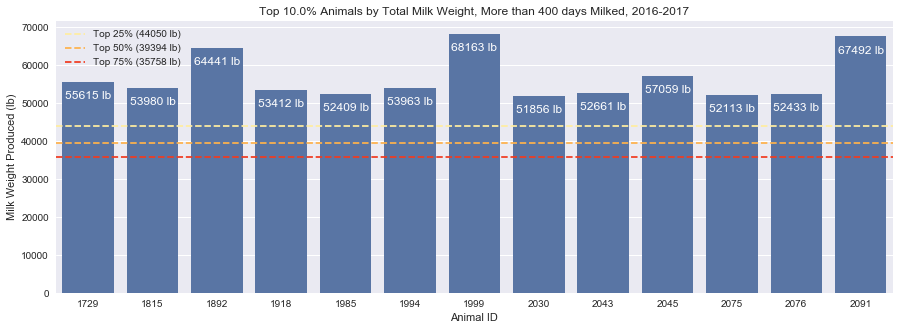

In [35]:
def plot_top_performers(performance_profiles, top_percentage=0.10):
    target_quantile = 1 - top_percentage
    target_milk = performance_profiles['Total Milk-Pounds'].quantile(target_quantile)
    data = performance_profiles[performance_profiles['Total Milk-Pounds'] > target_milk]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax = sns.barplot(ax=ax, y='Total Milk-Pounds', x='Animal ID', data=data, palette=sns.color_palette(n_colors=1))
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Weight Produced (lb)')
    
    percentile = top_percentage * 100
    _ = plt.title(f'Top {percentile}% Animals by Total Milk Weight, More than 400 days Milked, 2016-2017')
    
    top_quarter = performance_profiles['Total Milk-Pounds'].quantile(0.75)
    line_25 = ax.axhline(top_quarter, ls='--', c='#ffeda0', label='Top 25%')
    
    top_half = performance_profiles['Total Milk-Pounds'].quantile(0.50)
    line_50 = ax.axhline(top_half, ls='--', c='#feb24c', label='Top 50%')
    
    top_three_quarters = performance_profiles['Total Milk-Pounds'].quantile(0.25)
    line_75 = ax.axhline(top_three_quarters, ls='--', c='#f03b20', label='Top 75%')
    
    plt.legend([line_25, line_50, line_75], 
               [f'Top 25% ({int(top_quarter)} lb)',
                f'Top 50% ({int(top_half)} lb)',
                f'Top 75% ({int(top_three_quarters)} lb)'], 
               loc='best')
    
    ax = plt.gca()
    for p in ax.patches:
        _ = ax.text(p.get_x() + p.get_width()/2., 
                    p.get_height() - 5000, 
                    '%d lb' % int(p.get_height()), 
                    fontsize=12, color='white', ha='center', va='bottom')
    return data

top_ten_percent = plot_top_performers(performance_profiles, top_percentage=0.1)
save_plot_for_summary_report('top-producers.png')
plt.show()

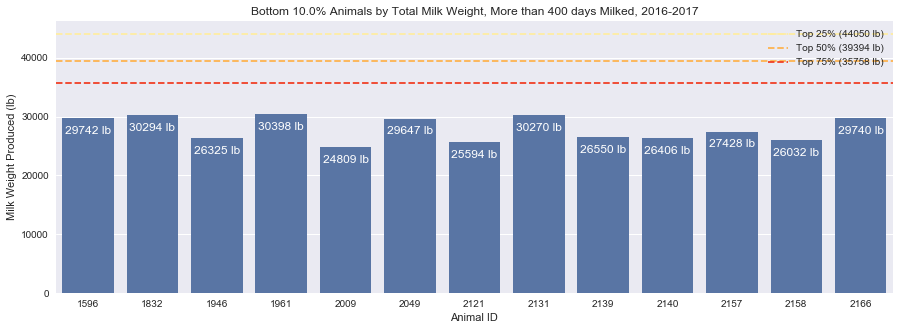

In [34]:
def plot_bottom_performers(performance_profiles, bottom_percentage=0.10):
    target_milk = performance_profiles['Total Milk-Pounds'].quantile(bottom_percentage)
    data = performance_profiles[performance_profiles['Total Milk-Pounds'] < target_milk]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax = sns.barplot(ax=ax, y='Total Milk-Pounds', x='Animal ID', data=data, palette=sns.color_palette(n_colors=1))
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Weight Produced (lb)')
    
    percentile = bottom_percentage * 100
    _ = plt.title(f'Bottom {percentile}% Animals by Total Milk Weight, More than 400 days Milked, 2016-2017')
    
    top_quarter = performance_profiles['Total Milk-Pounds'].quantile(0.75)
    line_25 = ax.axhline(top_quarter, ls='--', c='#ffeda0', label='Top 25%')
    
    top_half = performance_profiles['Total Milk-Pounds'].quantile(0.50)
    line_50 = ax.axhline(top_half, ls='--', c='#feb24c', label='Top 50%')
    
    top_three_quarters = performance_profiles['Total Milk-Pounds'].quantile(0.25)
    line_75 = ax.axhline(top_three_quarters, ls='--', c='#f03b20', label='Top 75%')
    
    plt.legend([line_25, line_50, line_75], 
               [f'Top 25% ({int(top_quarter)} lb)',
                f'Top 50% ({int(top_half)} lb)',
                f'Top 75% ({int(top_three_quarters)} lb)'], 
               loc='best')
    
    ax = plt.gca()
    for p in ax.patches:
        _ = ax.text(p.get_x() + p.get_width()/2., 
                    p.get_height() - 3000, 
                    '%d lb' % int(p.get_height()), 
                    fontsize=12, color='white', ha='center', va='bottom')
    return data

bottom_ten_percent = plot_bottom_performers(performance_profiles, bottom_percentage=0.1)
save_plot_for_summary_report('bottom-producers.png')
plt.show()